In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from model import uncertainty_decomposition
from utilities import find_nearest_value
from numba import njit

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [100]:
ϵ = .5

ξ_w=1000.
ξ_p=1./25
ξ_a=1./3000

# damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
#                 'πd_o': np.array([1./3, 1./3, 1./3])}
damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([.475, .475, .05])}
# damage_setting={'γ_2p': np.array([0, .0197*2]),
#                 'πd_o': np.array([.5, .5])}

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ_i
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)

ME_total = δ*η/model_res['e_tilde']

Converged. Total iteration 5000: LHS Error: 5.767133888501252e-07; RHS Error 8.260435716617902e-07
Converged. Total iteration 2058: LHS Error: 9.98032525373338e-09; RHS Error 5.286745306765756e-06
Converged. Total iteration 2305: LHS Error: 9.991708682655087e-09; RHS Error 2.2506646237165286e-05
Converged. Total iteration 522: LHS Error: 9.973912959426734e-09; RHS Error 4.879111920932e-06


In [101]:
# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 463: LHS Error: 9.932885777774736e-09; RHS Error 3.909429059397894e-06
Converged. Total iteration 452: LHS Error: 9.920163565602103e-09; RHS Error 4.8793263061021525e-06
Converged. Total iteration 460: LHS Error: 9.750508345174325e-09; RHS Error 3.86371407149036e-06
Converged. Total iteration 453: LHS Error: 9.862493460799371e-09; RHS Error 4.880089363115724e-06
Converged. Total iteration 457: LHS Error: 9.603352391085451e-09; RHS Error 4.9482967635264665e-06
Converged. Total iteration 462: LHS Error: 9.630865896448348e-09; RHS Error 3.8145969399912944e-06
Converged. Total iteration 463: LHS Error: 9.631493588790896e-09; RHS Error 3.6268527024811703e-06
Converged. Total iteration 463: LHS Error: 9.578353887818025e-09; RHS Error 3.803199312859759e-06


(0.0, 35.0)

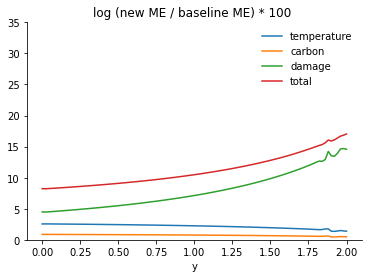

In [102]:
plt.title('log (new ME / baseline ME) * 100 ')
# plt.plot(y_grid_short, np.log(ME_temp_carb/ME_baseline)*(100), label='temperature + carbon')
plt.plot(y_grid_short, np.log(ME_temp/ME_baseline)*(100), label='temperature')
plt.plot(y_grid_short, np.log(ME_carb/ME_baseline)*(100), label='carbon')
plt.plot(y_grid_short, np.log(ME_damage/ME_baseline)*(100), label='damage')
plt.plot(y_grid_short, np.log(ME_total/ME_baseline)*(100), label='total')
# plt.plot(y_grid_short, np.log(ME_temp_damage/ME_baseline)*(100), label='temperature+damage')
# plt.plot(y_grid_short, np.log(ME_carb_damage/ME_baseline)*(100), label='carbon+damage')
# plt.plot(y_grid_short, np.log(ME_total_check/ME_baseline)*(100), label='total check')

plt.legend(frameon=False)
plt.xlabel('y')
plt.ylim(0, 35)